# <b><u> Project Title : Sentiment Analysis : COVID-19 tweets</u></b>

## <b> Problem Description </b>

### Classification model to predict the sentiment of COVID-19 tweets.

<img src="image.png" width=1000 height=1000 />

In [60]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

## Reviewing dataset

In [61]:
df = pd.read_csv('covid_tweets.csv',encoding = 'latin')

In [62]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Location has null values, but it is not required in sentiment analysis so we'll neglect it.

In [64]:
df.shape

(41157, 6)

There are 41157 rows and 6 columns in the dataset

In [65]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UserName,41157,NaN,NaN,NaN,24377,11881.1,3799,14088,24377,34666,44955
ScreenName,41157,NaN,NaN,NaN,69329,11881.1,48751,59040,69329,79618,89907
Location,32567,12220,London,540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TweetAt,41157,30,20-03-2020,3448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OriginalTweet,41157,41157,Just keep going I know it s difficult right ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sentiment,41157,5,Positive,11422,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

## Data Visualization

In [67]:
# Top 10 locations of tweet

Top_Location_Of_tweet = df['Location'].value_counts().head(10)
Top_Location_Of_tweet

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

In [68]:
Top_Location_Of_tweet_df=pd.DataFrame(Top_Location_Of_tweet)
Top_Location_Of_tweet_df.reset_index(inplace=True)
Top_Location_Of_tweet_df.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)
Top_Location_Of_tweet_df

,Location,Location_Count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


Text(0.5, 0, 'Location Names')

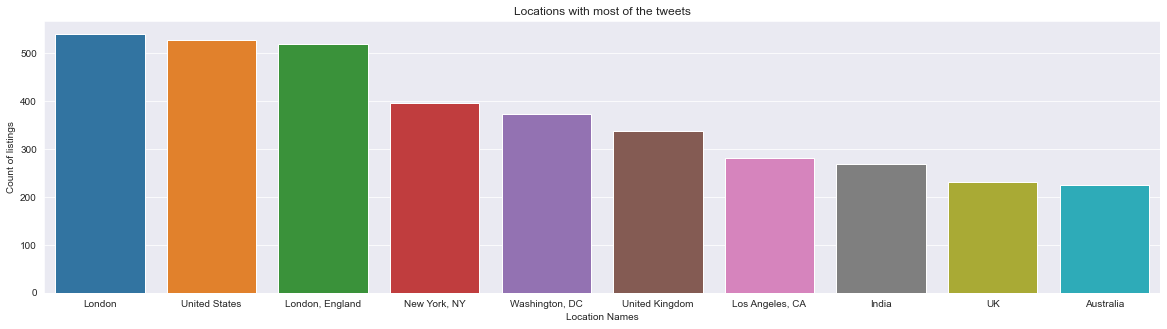

In [69]:
sns.set_style('darkgrid')
plt.figure(figsize = (20, 5))

location_plot =sns.barplot(x="Location", y="Location_Count", data=Top_Location_Of_tweet_df)
location_plot.set_title('Locations with most of the tweets')
location_plot.set_ylabel('Count of listings')
location_plot.set_xlabel('Location Names')
# location_plot.set_xticklabels(location_plot.get_xticklabels(), rotation=45)

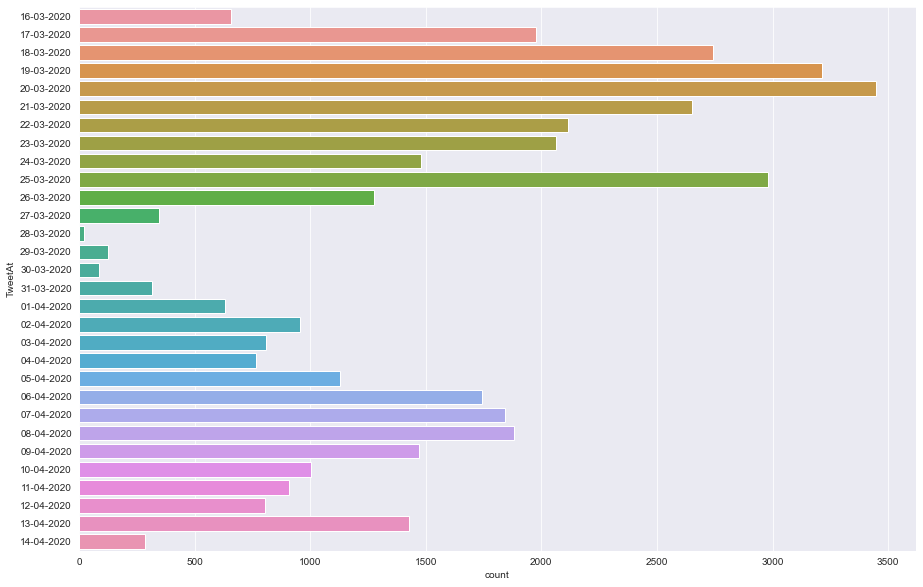

In [70]:
plt.figure(figsize = (15, 10))
sns.countplot(y = 'TweetAt', data = df)

Tweets are made between 16th March 2020 and 14th April 2020.   
Most of the tweets are made in the month of March

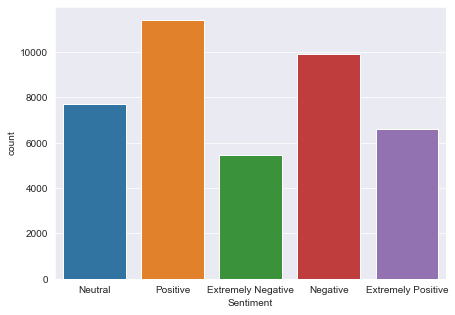

In [71]:
plt.figure(figsize = (7, 5))
sns.countplot(x = 'Sentiment', data = df)

## Data Preprocessing

In [72]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


UserName, ScreenName, and Location, TweetAt are not needed for sentiment analysis

In [73]:
df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1, inplace = True)

In [74]:
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


**A) Removing @user**

In [75]:
import re

In [76]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [77]:
df['Clean_Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')
df.head()

,OriginalTweet,Sentiment,Clean_Tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX...
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the #COV..."


**B) Removing HTTP and URLS**

In [78]:
df['Clean_Tweet'] = df['Clean_Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df.head()

,OriginalTweet,Sentiment,Clean_Tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the #COV..."


**C) Removing Punctuations, Numbers, and Special Characters**

In [79]:
df['Clean_Tweet'] = df['Clean_Tweet'].str.replace('[^a-zA-Z#]+',' ')
df.head()

,OriginalTweet,Sentiment,Clean_Tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Me ready to go at supermarket during the #COVI...


**D) Removing Short Words**

In [80]:
df['Clean_Tweet'] = df['Clean_Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
df.head()

,OriginalTweet,Sentiment,Clean_Tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,advice Talk your neighbours family exchange ph...
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths give elderly ...
3,My food stock is not the only one which is emp...,Positive,food stock not the only one which empty PLEASE...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready supermarket during the #COVID outbreak N...


**E) Tokenization**

In [81]:
tokenized_tweet = df['Clean_Tweet'].apply(lambda x: x.lower().split())
tokenized_tweet

0                                                       []
1        [advice, talk, your, neighbours, family, excha...
2        [coronavirus, australia, woolworths, give, eld...
3        [food, stock, not, the, only, one, which, empt...
4        [ready, supermarket, during, the, #covid, outb...
                               ...                        
41152    [airline, pilots, offering, stock, supermarket...
41153    [response, complaint, not, provided, citing, c...
41154    [you, know, getting, tough, when, rationing, t...
41155    [wrong, that, the, smell, hand, sanitizer, sta...
41156    [well, new, used, rift, are, going, for, amazo...
Name: Clean_Tweet, Length: 41157, dtype: object

**F) Stemming and Removing Stopwords**

In [82]:
from nltk.stem.porter import *
from nltk.corpus import stopwords

In [83]:
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x if i not in stopwords.words('english')])
tokenized_tweet

0                                                       []
1        [advic, talk, neighbour, famili, exchang, phon...
2        [coronaviru, australia, woolworth, give, elder...
3        [food, stock, one, empti, pleas, panic, enough...
4        [readi, supermarket, #covid, outbreak, paranoi...
                               ...                        
41152    [airlin, pilot, offer, stock, supermarket, she...
41153    [respons, complaint, provid, cite, covid, rela...
41154    [know, get, tough, ration, toilet, paper, #cor...
41155    [wrong, smell, hand, sanit, start, turn, #coro...
41156    [well, new, use, rift, go, amazon, although, n...
Name: Clean_Tweet, Length: 41157, dtype: object

In [84]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
df['Clean_Tweet']  = tokenized_tweet
df.head()

,OriginalTweet,Sentiment,Clean_Tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...
3,My food stock is not the only one which is emp...,Positive,food stock one empti pleas panic enough food e...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,readi supermarket #covid outbreak paranoid foo...


In [85]:
del df['OriginalTweet']

In [86]:
df.head()

,Sentiment,Clean_Tweet
0,Neutral,
1,Positive,advic talk neighbour famili exchang phone numb...
2,Positive,coronaviru australia woolworth give elderli di...
3,Positive,food stock one empti pleas panic enough food e...
4,Extremely Negative,readi supermarket #covid outbreak paranoid foo...


## Words Visualization

**A) All Words**

In [87]:
from wordcloud import WordCloud 

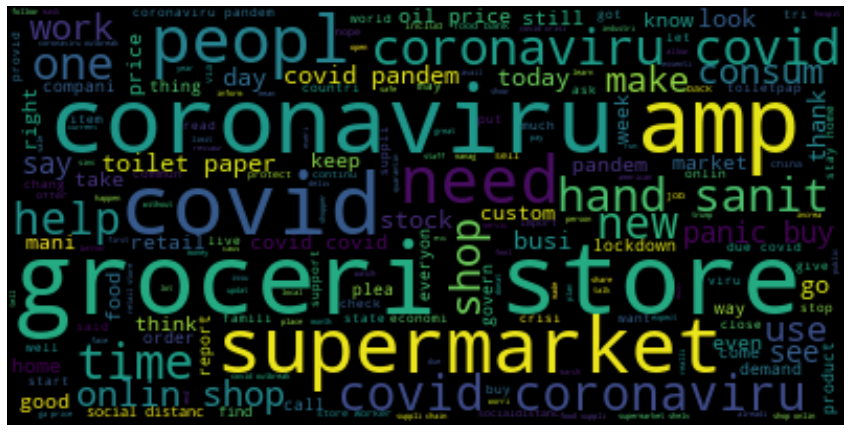

In [88]:
all_words = ' '.join([text for text in df['Clean_Tweet']])

wordcloud = WordCloud().generate(all_words)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**B) Extremely Positive Words**

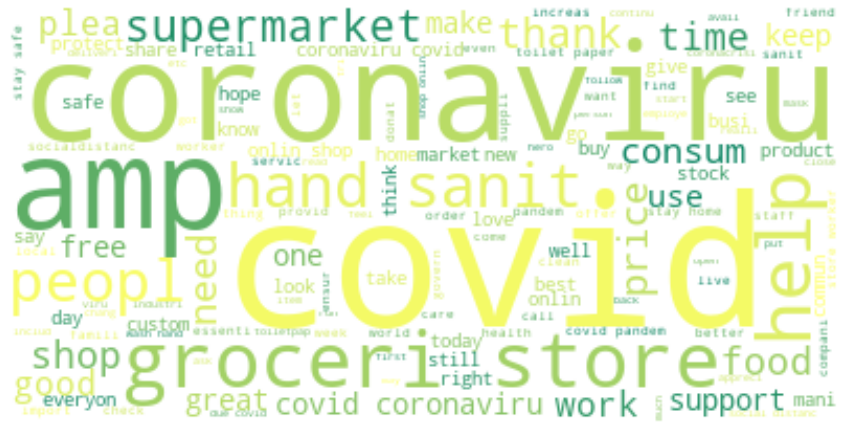

In [89]:
exp_words = ' '.join([text for text in df['Clean_Tweet'][df['Sentiment'] == 'Extremely Positive']])

wordcloud = WordCloud(background_color="white", colormap='summer').generate(exp_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**C) Positive Words**

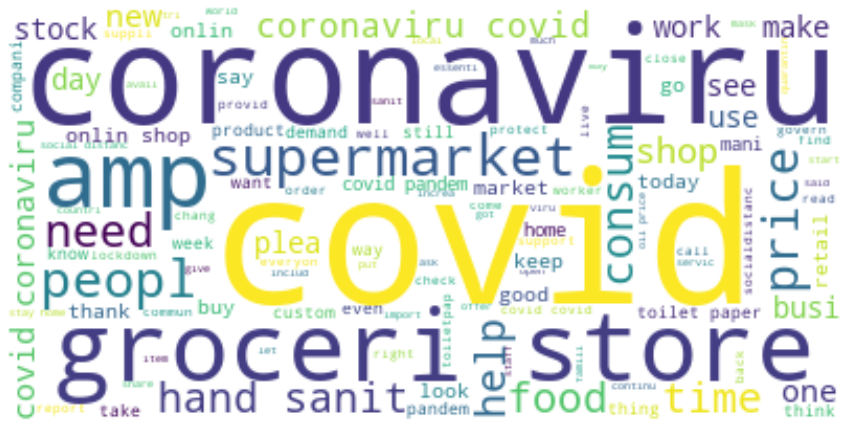

In [90]:
positive_words = ' '.join([text for text in df['Clean_Tweet'][df['Sentiment'] == 'Positive']])

wordcloud = WordCloud(background_color="white").generate(positive_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**D) Neutral Words**

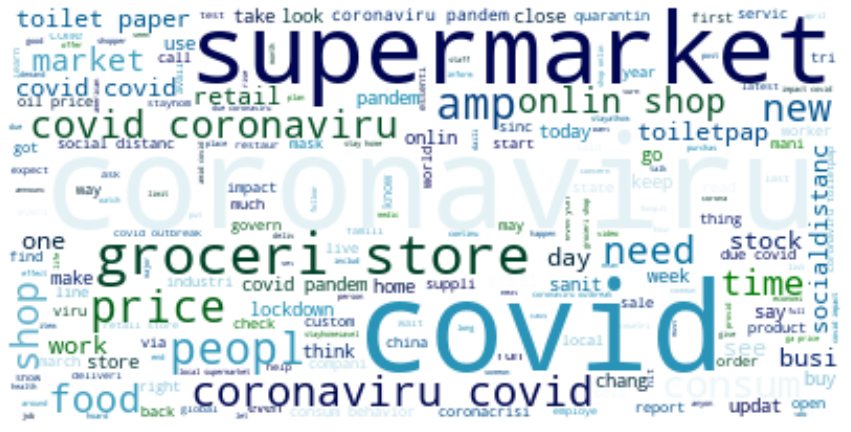

In [91]:
neutral_words = ' '.join([text for text in df['Clean_Tweet'][df['Sentiment'] == 'Neutral']])

wordcloud = WordCloud(background_color="white", colormap='ocean').generate(neutral_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**E) Negative Words**

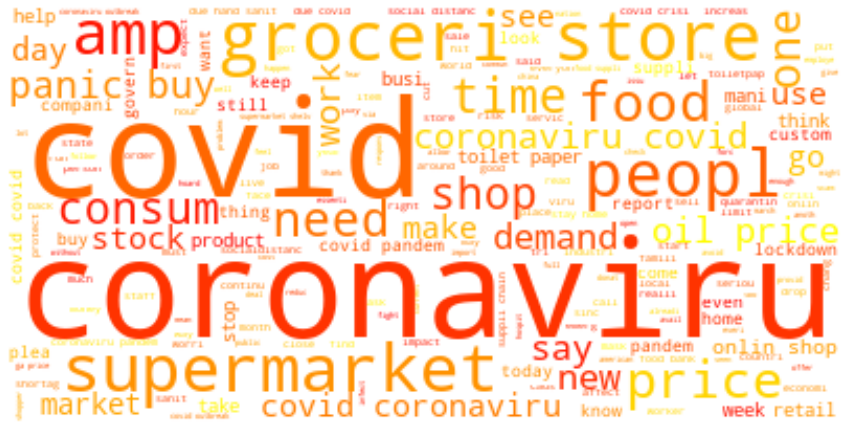

In [92]:
negative_words = ' '.join([text for text in df['Clean_Tweet'][df['Sentiment'] == 'Negative']])

wordcloud = WordCloud(background_color="white", colormap='autumn').generate(negative_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**F) Extremely Negative Words**

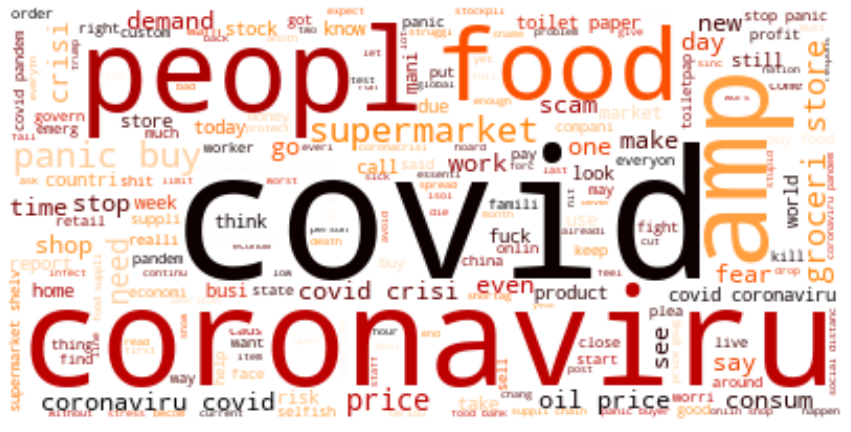

In [93]:
exn_words = ' '.join([text for text in df['Clean_Tweet'][df['Sentiment'] == 'Extremely Negative']])

wordcloud = WordCloud(background_color="white", colormap='gist_heat').generate(exn_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Impact of Hashtags

In [94]:
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [95]:
HT_Extremely_Positive = hashtag_extract(df['Clean_Tweet'][df['Sentiment'] == 'Extremely Positive'])
HT_Positive = hashtag_extract(df['Clean_Tweet'][df['Sentiment'] == 'Positive'])
HT_Neutral = hashtag_extract(df['Clean_Tweet'][df['Sentiment'] == 'Neutral'])
HT_Negative = hashtag_extract(df['Clean_Tweet'][df['Sentiment'] == 'Negative'])
HT_Extremely_Negative = hashtag_extract(df['Clean_Tweet'][df['Sentiment'] == 'Extremely Negative'])

# unnesting list
HT_Extremely_Positive = sum(HT_Extremely_Positive, [])
HT_Positive = sum(HT_Positive, [])
HT_Neutral = sum(HT_Neutral, [])
HT_Negative = sum(HT_Negative,[])
HT_Extremely_Negative = sum(HT_Extremely_Negative,[])

In [96]:
def plot_hashtag(data):
    a = nltk.FreqDist(data)
    d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count' : list(a.values())})
    d = d.nlargest(columns = 'Count', n = 10)

    plt.figure(figsize = (16,5))
    ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
    plt.show()

**A) Extremely Positive Hashtags**

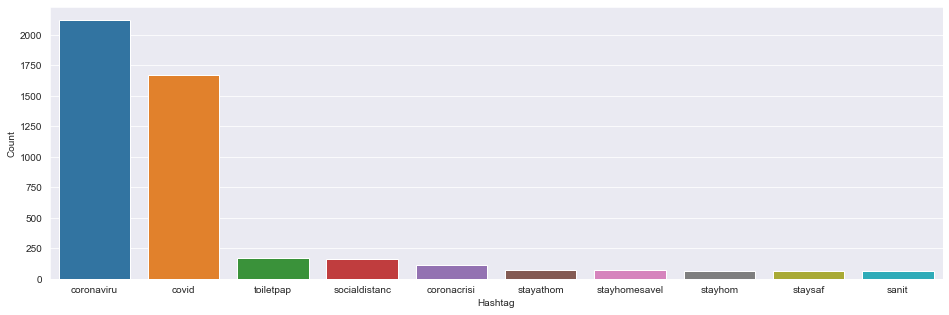

In [97]:
plot_hashtag(HT_Extremely_Positive)

**B) Positive Hashtags**

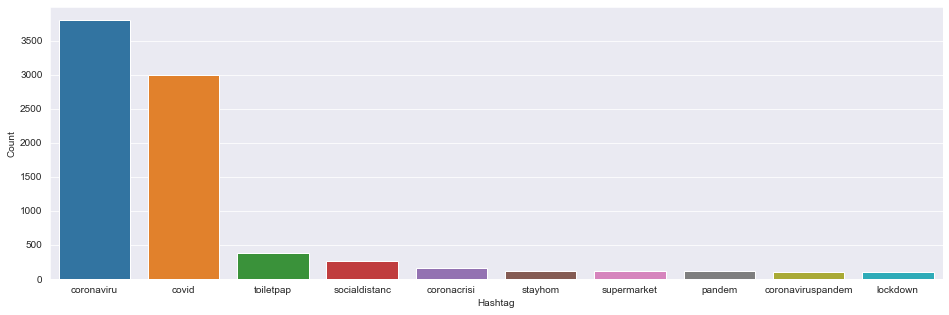

In [98]:
plot_hashtag(HT_Positive)

**C) Neutral Hashtags**

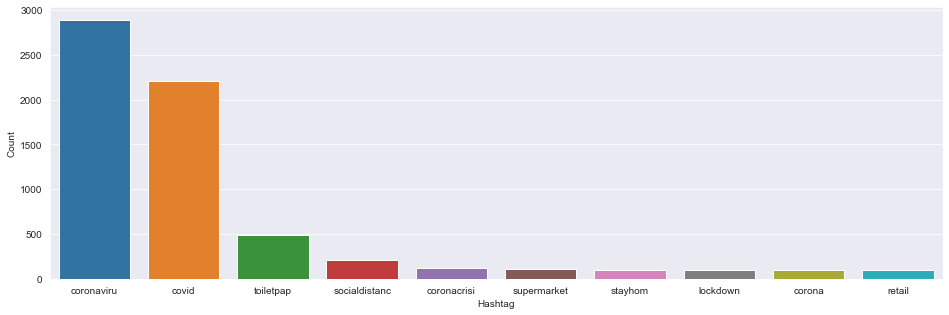

In [99]:
plot_hashtag(HT_Neutral)

**D) Negative Hashtags**

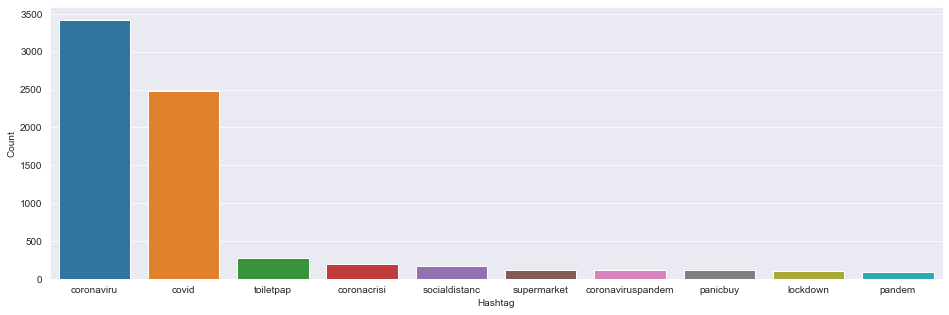

In [100]:
plot_hashtag(HT_Negative)

**E) Extremely Negative Hashtags**

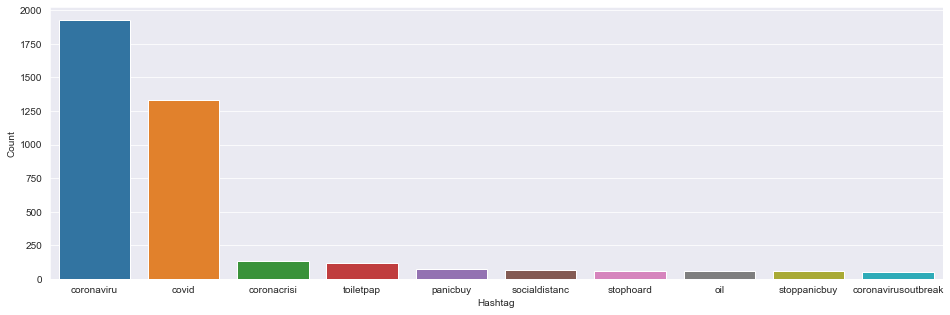

In [101]:
plot_hashtag(HT_Extremely_Negative)

From the above analysis, we got to know that extremely positive, positive and neutral responses ar almost same, and extremely negative and negative responses are almost same,   
therefore, converting the classification into binary classification

## Binary Classification

In [102]:
df["Sentiment"]= df["Sentiment"].replace('Positive',1) 
df["Sentiment"]= df["Sentiment"].replace('Extremely Positive',1) 
df["Sentiment"]= df["Sentiment"].replace('Neutral',1) 
df["Sentiment"]= df["Sentiment"].replace('Negative',0) 
df["Sentiment"]= df["Sentiment"].replace('Extremely Negative',0) 

In [103]:
df.head()

,Sentiment,Clean_Tweet
0,1,
1,1,advic talk neighbour famili exchang phone numb...
2,1,coronaviru australia woolworth give elderli di...
3,1,food stock one empti pleas panic enough food e...
4,0,readi supermarket #covid outbreak paranoid foo...


# Splitting Our Dataset into Training And Testing Dataset

In [104]:
from sklearn.model_selection import train_test_split

def split_data():
    train, test = train_test_split(df,test_size = 0.25,random_state=0,stratify = df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
    print("train shape : ", train.shape)
    print("test shape : ", test.shape)
    return train, test

In [105]:
train, test = split_data()

train shape :  (30867, 2)
test shape :  (10290, 2)


# Use Of Counter Vectorizer

In [106]:
from sklearn.feature_extraction.text import CountVectorizer
def vectorizer():
    vectorizer = CountVectorizer()

    xtrain = vectorizer.fit_transform(train.Clean_Tweet.values)
    xtest = vectorizer.transform(test.Clean_Tweet.values)

    ytrain = train.Sentiment.values
    ytest = test.Sentiment.values

    print("xtrain.shape : ", xtrain.shape)
    print("xtrain.shape : ", xtest.shape)
    print("ytrain.shape : ", ytrain.shape)
    print("ytest.shape : ", ytest.shape)
    return xtrain, xtest, ytrain, ytest

In [107]:
xtrain, xtest, ytrain, ytest = vectorizer()

xtrain.shape :  (30867, 26217)
xtrain.shape :  (10290, 26217)
ytrain.shape :  (30867,)
ytest.shape :  (10290,)


## Models

In [108]:
def prediction(model):
    ypred = model.predict(xtest)
    accuracy = accuracy_score(ytest, ypred)
    print("training accuracy Score    : ",model.score(xtrain, ytrain))
    print("Validation accuracy Score : ",accuracy )
    print(classification_report(ypred ,ytest))
        
    print()
    return accuracy

## Naive Bayes Classifier

In [109]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB().fit(xtrain, ytrain)
naiveByes_acc = prediction(naiveByes_clf)

training accuracy Score    :  0.8597531344153951
Validation accuracy Score :  0.7932944606413994
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      3551
           1       0.86      0.82      0.84      6739

    accuracy                           0.79     10290
   macro avg       0.77      0.78      0.78     10290
weighted avg       0.80      0.79      0.80     10290




# Stochastic Gradient Descent-SGD Classifier

In [110]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0).fit(xtrain, ytrain)
sgd_acc = prediction(sgd_clf)

training accuracy Score    :  0.9359834127061263
Validation accuracy Score :  0.8615160349854227
              precision    recall  f1-score   support

           0       0.76      0.85      0.81      3459
           1       0.92      0.87      0.89      6831

    accuracy                           0.86     10290
   macro avg       0.84      0.86      0.85     10290
weighted avg       0.87      0.86      0.86     10290




# RANDOM FOREST CLASSIFIER

In [111]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier().fit(xtrain,ytrain)
rf_acc = prediction(rf_clf)

training accuracy Score    :  0.9984773382576863
Validation accuracy Score :  0.8301263362487852
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      3354
           1       0.90      0.84      0.87      6936

    accuracy                           0.83     10290
   macro avg       0.81      0.83      0.81     10290
weighted avg       0.84      0.83      0.83     10290




# Extreme Gradient Boosting

In [112]:
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier().fit(xtrain, ytrain)
xgb_acc = prediction(xgboost_clf)

[16:35:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
training accuracy Score    :  0.8531117374542392
Validation accuracy Score :  0.8197278911564626
              precision    recall  f1-score   support

           0       0.64      0.84      0.73      2905
           1       0.93      0.81      0.87      7385

    accuracy                           0.82     10290
   macro avg       0.78      0.83      0.80     10290
weighted avg       0.85      0.82      0.83     10290




# Support vector machine

In [113]:
from sklearn.svm import SVC

svc = SVC().fit(xtrain, ytrain)
svc_acc = prediction(svc)

training accuracy Score    :  0.9564583535814948
Validation accuracy Score :  0.8417881438289602
              precision    recall  f1-score   support

           0       0.68      0.86      0.76      3048
           1       0.94      0.83      0.88      7242

    accuracy                           0.84     10290
   macro avg       0.81      0.85      0.82     10290
weighted avg       0.86      0.84      0.85     10290




# Logistic Regression

In [114]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(xtrain, ytrain)
logreg_acc = prediction(logreg)

training accuracy Score    :  0.940033044999514
Validation accuracy Score :  0.8600583090379009
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      3448
           1       0.92      0.87      0.89      6842

    accuracy                           0.86     10290
   macro avg       0.84      0.86      0.85     10290
weighted avg       0.87      0.86      0.86     10290




# CATBOOST MODEL

In [115]:
from catboost import CatBoostClassifier

cat_clf = CatBoostClassifier().fit(xtrain, ytrain,  eval_set=(xtest, ytest), verbose=False)
cat_acc = prediction(cat_clf)

training accuracy Score    :  0.8859947516765477
Validation accuracy Score :  0.8513119533527697
              precision    recall  f1-score   support

           0       0.71      0.86      0.78      3184
           1       0.93      0.85      0.89      7106

    accuracy                           0.85     10290
   macro avg       0.82      0.85      0.83     10290
weighted avg       0.87      0.85      0.85     10290




# All the models test accuracy in descending order

In [119]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Descent', 'XGBoost','CatBoost'],
    'Test accuracy': [svc_acc, logreg_acc, 
              rf_acc, naiveByes_acc, 
              sgd_acc, xgb_acc,cat_acc]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
4,Stochastic Gradient Descent,0.861516
1,Logistic Regression,0.860058
6,CatBoost,0.851312
0,Support Vector Machines,0.841788
2,Random Forest,0.830126
5,XGBoost,0.819728
3,Naive Bayes,0.793294


## Finalizing Stochastic Gradient Descent Model

In [133]:
ypred = sgd_clf.predict(xtest)

In [121]:
from sklearn.metrics import f1_score, recall_score

In [129]:
print('f1_score : ', f1_score(ytest,ypred, average="macro"))
print('recall: ', recall_score(ytest,ypred, average="macro"))

f1_score :  0.8488289505387336
recall:  0.841938170525127


[[2942  517]
 [ 908 5923]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

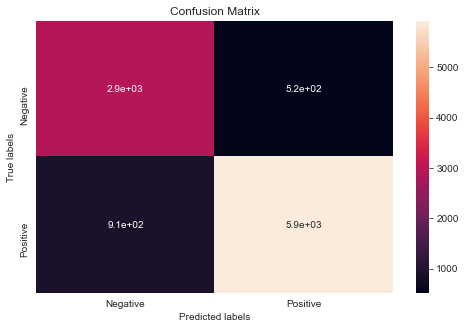

In [130]:
# Get the confusion matrix for both train and test. We are getting very low type and type 2 errors.

labels = ['Negative', 'Positive']
cm = confusion_matrix(ypred, ytest)
print(cm)

plt.figure(figsize = (8, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

#### Final Accuracy : 86.1%